# 🧠 Cognitive Performance Analyzer - Demo


## Setup


In [1]:
import sys
import os
import subprocess
from pathlib import Path

PROJECT_ROOT = Path(__file__).parent.parent if '__file__' in dir() else Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
os.chdir(PROJECT_ROOT)

sys.path.insert(0, str(PROJECT_ROOT / 'src'))

from dotenv import load_dotenv
load_dotenv(PROJECT_ROOT / '.env')

import psycopg2
import pandas as pd
from config.config import DB_CONFIG

print(f"✓ Setup complete (working dir: {PROJECT_ROOT})")


✓ Setup complete (working dir: /Users/justinduvivier/PycharmProjects/BrainFog)


## Step 1: Preview Input CSVs


In [2]:
external = pd.read_csv('data/external.csv')
behavioral = pd.read_csv('data/behavioral.csv')
cognitive = pd.read_csv('data/cognitive.csv')

print(f"External data: {len(external)} rows (weather, air quality)")
display(external.head(3))

print(f"\nBehavioral data: {len(behavioral)} rows (sleep, steps, nutrition)")
display(behavioral.head(3))

print(f"\nCognitive data: {len(cognitive)} rows (memory, reaction time)")
display(cognitive.head(3))


External data: 168 rows (weather, air quality)


,person,timestamp,pressure_hpa,pressure_change_24h,temperature,humidity,hour_of_day,day_of_week,weekend,pm25,aqi,co,no,no2,o3,so2,pm10,nh3
0,Deshaun,2025-11-22 07:00:00,1013.5,1.9,46.0,61.0,7,5,True,9.2,37,0.34,0.016,15.2,41.0,2.3,12.5,1.3
1,Emily,2025-11-22 07:00:00,1012.8,1.6,44.0,64.0,7,5,True,8.0,33,0.30,0.013,13.5,43.2,2.0,11.5,1.0
2,Justin,2025-11-22 07:00:00,1013.2,1.8,45.0,62.0,7,5,True,9.1,37,0.34,0.016,15.2,41.0,2.3,12.5,1.3



Behavioral data: 168 rows (sleep, steps, nutrition)


,person,timestamp,sleep_hours,phone_usage,steps,screen_time_minutes,active_energy_kcal,calories_intake,protein_g,carbs_g,fat_g
0,Deshaun,2025-11-22 07:00:00,7.2,12,8500,105,380.0,2400.0,85.0,260.0,82.0
1,Emily,2025-11-22 07:00:00,6.5,18,3200,185,420.0,1850.0,78.0,195.0,62.0
2,Justin,2025-11-22 07:00:00,7.5,12,4200,120,320.0,2100.0,95.0,220.0,70.0



Cognitive data: 168 rows (memory, reaction time)


,person,timestamp,sequence_memory_score,reaction_time_ms,verbal_memory_words
0,Deshaun,2025-11-22 07:00:00,7,262.0,12
1,Emily,2025-11-22 07:00:00,5,278.0,10
2,Justin,2025-11-22 07:00:00,7,258.0,13


## Step 2: Data Transformation Preview

Demonstrates how raw data is cleaned and standardized before loading.


In [4]:
from cleaners.clean import clean_measurement_external, clean_measurement_user

# Sample raw record from external data
raw_external = external.iloc[0].to_dict()
print("RAW External Record:")
for k, v in raw_external.items():
    print(f"  {k}: {v} ({type(v).__name__})")

# Clean it
cleaned_external = clean_measurement_external(raw_external)
print("\nCLEANED External Record:")
for k, v in cleaned_external.items():
    print(f"  {k}: {v} ({type(v).__name__})")

print("\n" + "="*50)

# Sample raw record from behavioral/cognitive data
raw_user = behavioral.iloc[0].to_dict()
raw_user.update(cognitive.iloc[0].to_dict())
print("\nRAW User Record:")
for k, v in list(raw_user.items())[:8]:
    print(f"  {k}: {v} ({type(v).__name__})")
print("  ...")

# Clean it
cleaned_user = clean_measurement_user(raw_user)
print("\nCLEANED User Record:")
for k, v in list(cleaned_user.items())[:8]:
    print(f"  {k}: {v} ({type(v).__name__})")
print("  ...")


RAW External Record:
  person: Deshaun (str)
  timestamp: 2025-11-22 07:00:00 (str)
  pressure_hpa: 1013.5 (float)
  pressure_change_24h: 1.9 (float)
  temperature: 46.0 (float)
  humidity: 61.0 (float)
  hour_of_day: 7 (int)
  day_of_week: 5 (int)
  weekend: True (bool)
  pm25: 9.2 (float)
  aqi: 37 (int)
  co: 0.34 (float)
  no: 0.016 (float)
  no2: 15.2 (float)
  o3: 41.0 (float)
  so2: 2.3 (float)
  pm10: 12.5 (float)
  nh3: 1.3 (float)

CLEANED External Record:
  person: Deshaun (str)
  timestamp: 2025-11-22 07:00:00 (datetime)
  pressure_hpa: 1013.5 (float)
  pressure_change_24h: 1.9 (float)
  temperature: 46.0 (float)
  humidity: 61.0 (float)
  hour_of_day: 7 (int)
  day_of_week: 6 (int)
  weekend: True (bool)
  pm25: 9.2 (float)
  aqi: 37 (int)
  co: 0.34 (float)
  no: 0.016 (float)
  no2: 15.2 (float)
  o3: 41.0 (float)
  so2: 2.3 (float)
  pm10: 12.5 (float)
  nh3: 1.3 (float)


RAW User Record:
  person: Deshaun (str)
  timestamp: 2025-11-22 07:00:00 (str)
  sleep_hours: 7.2

## Step 3: Check Database State (Before)


In [5]:
def get_db_stats():
    db_conn = psycopg2.connect(**DB_CONFIG)
    cur = db_conn.cursor()
    
    cur.execute("SELECT COUNT(*) FROM persons")
    persons = cur.fetchone()[0]
    
    cur.execute("SELECT COUNT(*) FROM measurements")
    measurements = cur.fetchone()[0]
    
    cur.execute("SELECT COUNT(*) FROM rejected_records")
    rejected = cur.fetchone()[0]
    
    cur.close()
    db_conn.close()
    return {"persons": persons, "measurements": measurements, "rejected": rejected}

print("Database state BEFORE pipeline:")
get_db_stats()


Database state BEFORE pipeline:


{'persons': 4, 'measurements': 168, 'rejected': 0}

## Step 4: Run the Pipeline


In [6]:
from run_pipeline import run_pipeline

print("Running full pipeline...")
print("="*50)
run_pipeline()
print("="*50)
print("✓ Pipeline complete")


2025-12-08 09:22:10,214 - pipeline - INFO - ============================================================
2025-12-08 09:22:10,214 - pipeline - INFO - COGNITIVE PERFORMANCE PIPELINE - Starting
2025-12-08 09:22:10,214 - pipeline - INFO - ============================================================
2025-12-08 09:22:10,215 - run_pipeline - INFO - Reading external factors from CSV...
2025-12-08 09:22:10,224 - run_pipeline - INFO - Read 168 external records from CSV
2025-12-08 09:22:10,246 - run_pipeline - INFO - Reading user tracking data from CSVs...
2025-12-08 09:22:10,253 - run_pipeline - INFO - Read 168 user tracking records
2025-12-08 09:22:10,279 - pipeline - INFO - 
2025-12-08 09:22:10,279 - pipeline - INFO - PIPELINE SUMMARY
2025-12-08 09:22:10,279 - pipeline - INFO - Duration: 0.06 seconds
2025-12-08 09:22:10,279 - pipeline - INFO - 
2025-12-08 09:22:10,279 - pipeline - INFO - Total Records:
2025-12-08 09:22:10,280 - pipeline - INFO -   Read: 336
2025-12-08 09:22:10,280 - pipeline -

Running full pipeline...
✓ Pipeline complete


## Step 5: Inspect Cleaned Data
Preview the transformed records right before they would be inserted into PostgreSQL.


In [7]:
from readers.csv_reader import read_all_external_data, read_all_user_data
from cleaners.clean import clean_measurement_external, clean_measurement_user, prepare_for_insert

# Preview cleaned external records
ext_raw = read_all_external_data()[:3]
ext_cleaned = [prepare_for_insert(clean_measurement_external(r)) for r in ext_raw]
print("CLEANED External Records (first 3):")
display(pd.DataFrame(ext_cleaned))

# Preview cleaned user records
user_raw = read_all_user_data()[:3]
user_cleaned = [prepare_for_insert(clean_measurement_user(r)) for r in user_raw]
print("\nCLEANED User Records (first 3):")
display(pd.DataFrame(user_cleaned))


CLEANED External Records (first 3):


,person,timestamp,pressure_hpa,pressure_change_24h,temperature,humidity,hour_of_day,day_of_week,weekend,pm25,aqi,co,no,no2,o3,so2,pm10,nh3
0,Deshaun,2025-11-22 07:00:00,1013.5,1.9,46.0,61.0,7,6,True,9.2,37,0.34,0.016,15.2,41.0,2.3,12.5,1.3
1,Emily,2025-11-22 07:00:00,1012.8,1.6,44.0,64.0,7,6,True,8.0,33,0.30,0.013,13.5,43.2,2.0,11.5,1.0
2,Justin,2025-11-22 07:00:00,1013.2,1.8,45.0,62.0,7,6,True,9.1,37,0.34,0.016,15.2,41.0,2.3,12.5,1.3



CLEANED User Records (first 3):


,person,timestamp,sleep_hours,phone_usage,steps,screen_time_minutes,active_energy_kcal,calories_intake,protein_g,carbs_g,fat_g,sequence_memory_score,reaction_time_ms,verbal_memory_words
0,Deshaun,2025-11-22 07:00:00,7.2,12,8500,105,380.0,2400.0,85.0,260.0,82.0,7,262.0,12
1,Emily,2025-11-22 07:00:00,6.5,18,3200,185,420.0,1850.0,78.0,195.0,62.0,5,278.0,10
2,Justin,2025-11-22 07:00:00,7.5,12,4200,120,320.0,2100.0,95.0,220.0,70.0,7,258.0,13


## Step 6: Check Database State (After)


In [8]:
print("Database state AFTER pipeline:")
stats = get_db_stats()
print(stats)

conn = psycopg2.connect(**DB_CONFIG)
df = pd.read_sql("SELECT * FROM measurements ORDER BY timestamp DESC LIMIT 5", conn)
conn.close()

print("\nRecent measurements:")
display(df)


Database state AFTER pipeline:
{'persons': 4, 'measurements': 168, 'rejected': 0}

Recent measurements:


/var/folders/6k/n2svtqb53rdfp7n4q2srrj100000gn/T/ipykernel_28730/2733477849.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM measurements ORDER BY timestamp DESC LIMIT 5", conn)


,id,person_id,timestamp,pressure_hpa,pressure_change_24h,temperature,humidity,hour_of_day,day_of_week,weekend,...,steps,screen_time_minutes,active_energy_kcal,calories_intake,protein_g,carbs_g,fat_g,sequence_memory_score,reaction_time_ms,verbal_memory_words
0,5952,1,2025-12-05 22:00:00,1016.2,1.0,35.0,63.0,22,5,False,...,6800,158,410.0,2150.0,100.0,232.0,73.0,6,268.0,12
1,5953,3,2025-12-05 22:00:00,1015.9,0.8,34.0,64.0,22,5,False,...,7200,85,355.0,1950.0,105.0,210.0,68.0,7,258.0,13
2,5950,4,2025-12-05 22:00:00,1016.5,1.0,36.0,62.0,22,5,False,...,10000,142,445.0,2420.0,85.0,262.0,83.0,6,272.0,11
3,5951,2,2025-12-05 22:00:00,1015.9,0.8,34.0,64.0,22,5,False,...,6200,165,455.0,2100.0,82.0,230.0,72.0,5,282.0,10
4,5949,3,2025-12-05 14:00:00,1016.2,1.0,43.0,54.0,14,5,False,...,6500,72,345.0,1870.0,108.0,202.0,65.0,7,255.0,13


## Step 7: Generate Insights


In [9]:
print("Generating correlation heatmap and AI payload...")
result = subprocess.run(
    ['python', 'reports/scripts/generate_insights.py'],
    env={**os.environ, 'PYTHONPATH': 'src'},
    capture_output=True, text=True
)
print(result.stdout)
if result.stderr:
    print("Warnings:", result.stderr[:200])


Generating correlation heatmap and AI payload...
Done. Payload: /Users/justinduvivier/PycharmProjects/BrainFog/reports/insights/ai_prompt_payload.json
Plot: /Users/justinduvivier/PycharmProjects/BrainFog/reports/insights/correlation_heatmap.png

Warnings: /Users/justinduvivier/PycharmProjects/BrainFog/reports/scripts/generate_insights.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 D


## Step 8: Generate PDF Report


In [10]:
print("Generating AI-powered PDF report...")
result = subprocess.run(
    ['python', 'reports/scripts/generate_report.py'],
    env={**os.environ, 'PYTHONPATH': 'src'},
    capture_output=True, text=True
)
print(result.stdout)
print("\n✓ Report saved to: reports/insights/cognitive_performance_report.pdf")


Generating AI-powered PDF report...
Generating AI summary...
AI summary complete.

Report saved: /Users/justinduvivier/PycharmProjects/BrainFog/reports/insights/cognitive_performance_report.pdf


✓ Report saved to: reports/insights/cognitive_performance_report.pdf


## Step 9: Display Results


Correlation Heatmap:


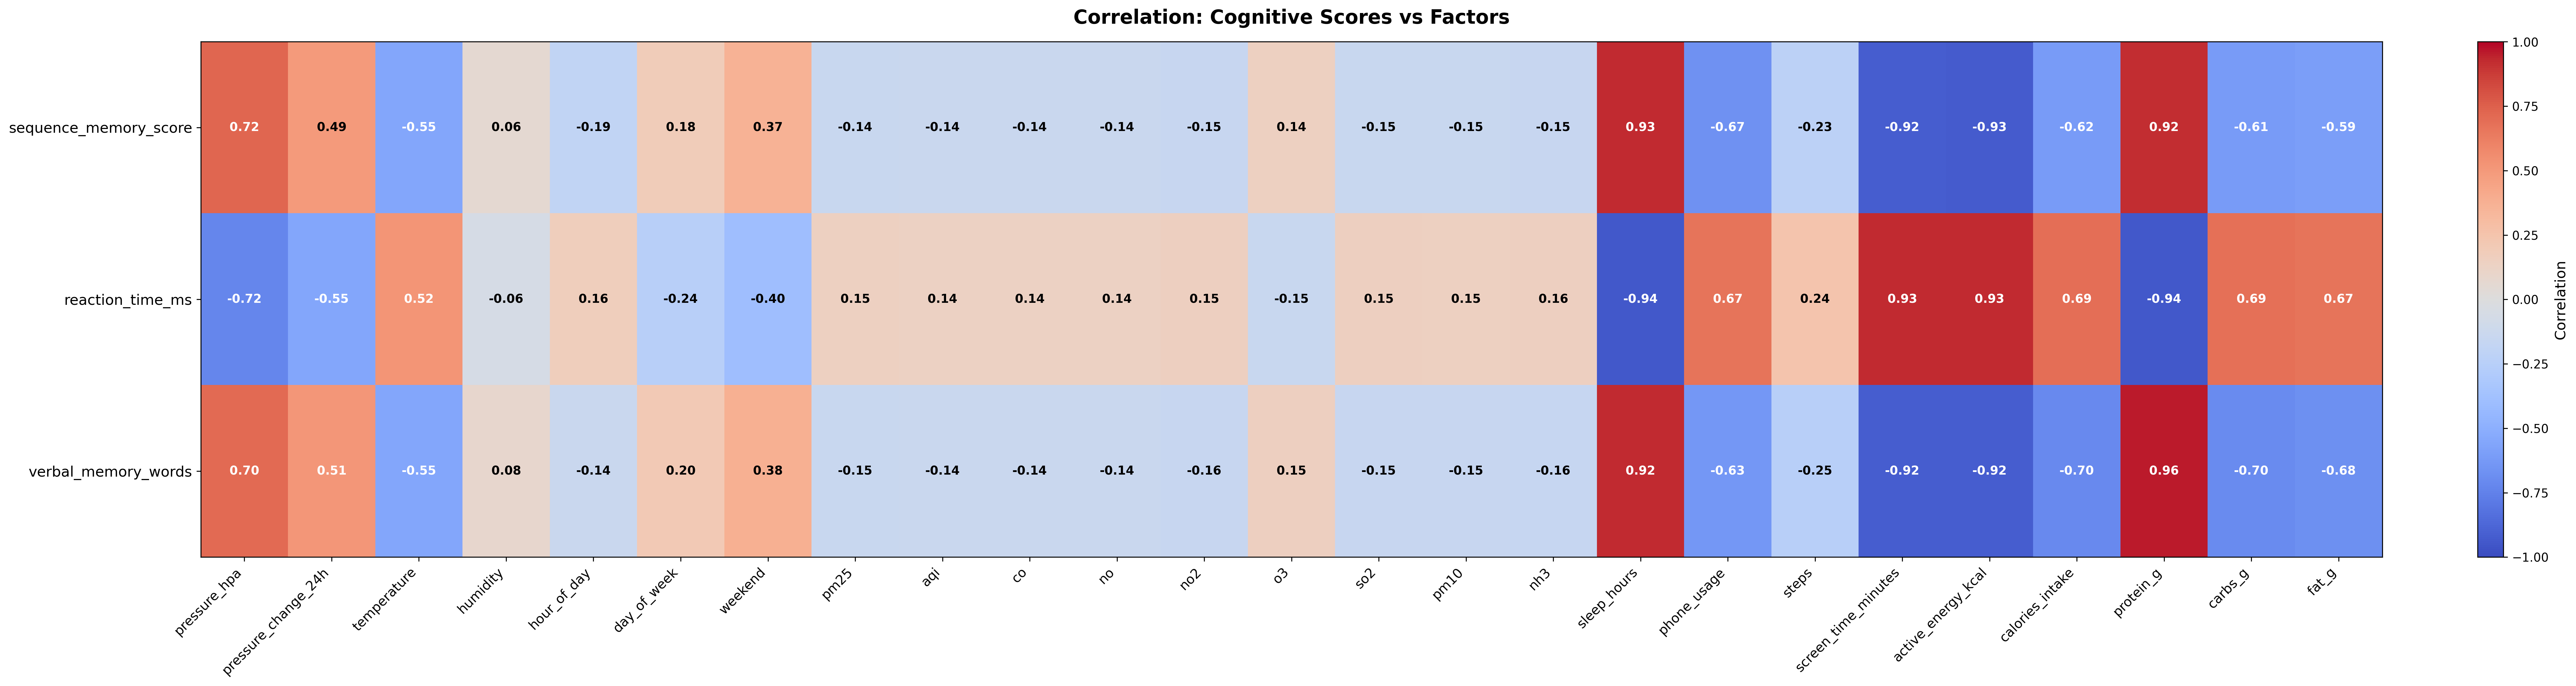

In [11]:
from IPython.display import Image, display

print("Correlation Heatmap:")
display(Image(filename=str(PROJECT_ROOT / 'reports/insights/correlation_heatmap.png'), width=800))


In [9]:
import json

with open(PROJECT_ROOT / 'reports/insights/ai_prompt_payload.json') as f:
    payload = json.load(f)

print(f"Dataset: {payload['summary']['rows']} measurements")
print("\nTop Correlations:")
for corr in payload['top_correlations'][:5]:
    print(f"  {corr['pair'][0]} ↔ {corr['pair'][1]}: {corr['corr']:.3f}")


Dataset: 168 measurements

Top Correlations:
  verbal_memory_words ↔ protein_g: 0.958
  reaction_time_ms ↔ protein_g: 0.943
  reaction_time_ms ↔ sleep_hours: 0.942
  reaction_time_ms ↔ screen_time_minutes: 0.930
  reaction_time_ms ↔ active_energy_kcal: 0.929


---
## Summary

The pipeline successfully:
1. ✓ Read behavioral & cognitive CSVs
2. ✓ Transformed and cleaned raw data
3. ✓ Validated all records
4. ✓ Loaded data into PostgreSQL
5. ✓ Generated correlation heatmap
6. ✓ Created AI-powered PDF report

**Output:** `reports/insights/cognitive_performance_report.pdf`
